# Introdução

O estudo dos métodos de interpretabilidade será feito com a base de dados de churn de cartão de crédito. No momento, passos de análise descritiva, construção, seleção e transformação de variáveis, calibração e distribuição das probabilidades serão pulados.

# Pacotes

In [44]:
# Precisei fazer o downgrade do numpy, por conflito de versão com o numba.
#!pip install numpy==2.0

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import zipfile


from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score, brier_score_loss
from sklearn import tree

# Pacotes para interpretabilidade
# Diverse Counterfactual Explanations (DiCE) for ML
import dice_ml
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import shap

# Conjunto de dados

In [2]:
zf = zipfile.ZipFile('/home/hugo/Documents/Git_GitHub/Estudo_Cartao_Credito/vCartao_Credito/0.Base/credit-card-customers.zip') 
dados = pd.read_csv(zf.open('BankChurners.csv'))
dados = dados.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis = 1)
dados.head()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0              39  ...                       1                      3   
1              44  ...                       1                      2   
2              36  ...                       1                      0   
3              34  ...                       4                      1   
4              21  ...                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000  

[5 rows x 21 columns]

In [3]:
# Volumetria: linhas e colunas

dados.shape

(10127, 21)

In [4]:
# Duplicidade

dados.duplicated().sum()

np.int64(0)

In [6]:
# Sem dados nulos

dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [11]:
# Variável resposta

dados['Attrition_Flag'].value_counts()

Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64

In [13]:
# Percentual da variável target

dados['Attrition_Flag'].value_counts()/dados.shape[0]*100

Attrition_Flag
Existing Customer    83.934038
Attrited Customer    16.065962
Name: count, dtype: float64

In [3]:
# Por simplicidade considerar algumas variáveis: Total_Revolving_Bal, Total_Ct_Chng_Q4_Q1, Total_Relationship_Count, Months_Inactive_12_mon e Gender

colunas = ['Total_Revolving_Bal', 'Total_Ct_Chng_Q4_Q1', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Gender', 'Attrition_Flag']
dados_filtrados = dados[colunas]

In [4]:
# Transformação da variável target e sexo em 0 - 1

mapa_churn = {
    'Existing Customer': 0,
    'Attrited Customer': 1
}

mapa_gender = {
    'M': 0,
    'F': 1
}

dados_filtrados.loc[:,'Attrition_Flag'] = dados_filtrados['Attrition_Flag'].map(mapa_churn)
dados_filtrados.loc[:,'Gender'] = dados_filtrados['Gender'].map(mapa_gender)

In [7]:
dados_filtrados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Total_Revolving_Bal       10127 non-null  int64  
 1   Total_Ct_Chng_Q4_Q1       10127 non-null  float64
 2   Total_Relationship_Count  10127 non-null  int64  
 3   Months_Inactive_12_mon    10127 non-null  int64  
 4   Gender                    10127 non-null  object 
 5   Attrition_Flag            10127 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 474.8+ KB


In [5]:
# Converte os dados de objeto para inteiros

dados_filtrados['Gender'] = dados_filtrados['Gender'].astype('int')
dados_filtrados['Attrition_Flag'] = dados_filtrados['Attrition_Flag'].astype('int')
dados_filtrados['Total_Revolving_Bal'] = dados_filtrados['Total_Revolving_Bal'].astype('float')

/tmp/ipykernel_47012/2969820935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_filtrados['Gender'] = dados_filtrados['Gender'].astype('int')
/tmp/ipykernel_47012/2969820935.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_filtrados['Attrition_Flag'] = dados_filtrados['Attrition_Flag'].astype('int')
/tmp/ipykernel_47012/2969820935.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [6]:
dados_filtrados.dtypes

Total_Revolving_Bal         float64
Total_Ct_Chng_Q4_Q1         float64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Gender                        int64
Attrition_Flag                int64
dtype: object

In [14]:
# Validação

dados_filtrados['Attrition_Flag'].value_counts()

Attrition_Flag
0    8500
1    1627
Name: count, dtype: int64

In [10]:
# Presença de dados duplicados

dados_filtrados.duplicated().sum()

np.int64(205)

In [6]:
# Remove os dados duplicados

dados_filtrados = dados_filtrados.drop_duplicates()

In [7]:
# Variáveis explicativas e resposta

X = dados_filtrados.drop(['Attrition_Flag'], axis = 1)
y = dados_filtrados['Attrition_Flag']

In [8]:
# Divisão da base em treino, validação e teste

# 80% para treino e 20% para teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=.20, stratify=y, random_state=1234)

# Dos 80% -> 90% para treino e 10% para validação
X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=.10, stratify=y_treino, random_state=1234)

# Modelos

## Gradient Boosting

In [9]:
# https://scikit-learn.org/1.6/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

GBC = GradientBoostingClassifier(n_estimators=50, 
                                 learning_rate=0.05,
                                 max_depth=5,
                                 random_state=123)
GBC.fit(X_treino, y_treino)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=50,
                           random_state=123)

In [10]:
print("Métricas na base de TREINO")

print("Área abaixo da curva precision x recall:", average_precision_score(y_true=y_treino,y_score=GBC.predict_proba(X_treino)[:,1]))
print("Brier-score:", brier_score_loss(y_true=y_treino,y_proba=GBC.predict_proba(X_treino)[:,1]))

# Ponto de corte default: 0.5
print("F1-score:", f1_score(y_true=y_treino, y_pred=GBC.predict(X_treino)))
print("Precisão:", precision_score(y_true=y_treino, y_pred=GBC.predict(X_treino)))
print("Recall:", recall_score(y_true=y_treino, y_pred=GBC.predict(X_treino)))

Métricas na base de TREINO
Área abaixo da curva precision x recall: 0.7608824819830008
Brier-score: 0.07053511600602985
F1-score: 0.6378923766816144
Precisão: 0.8454680534918276
Recall: 0.5121512151215122


In [11]:
print("Métricas na base de Validação")

print("Área abaixo da curva precision x recall:", average_precision_score(y_true=y_val,y_score=GBC.predict_proba(X_val)[:,1]))
print("Brier-score:", brier_score_loss(y_true=y_val,y_proba=GBC.predict_proba(X_val)[:,1]))

# Ponto de corte default: 0.5
print("F1-score:", f1_score(y_true=y_val, y_pred=GBC.predict(X_val)))
print("Precisão:", precision_score(y_true=y_val, y_pred=GBC.predict(X_val)))
print("Recall:", recall_score(y_true=y_val, y_pred=GBC.predict(X_val)))

Métricas na base de Validação
Área abaixo da curva precision x recall: 0.7404162274746765
Brier-score: 0.07192687675230944
F1-score: 0.6185567010309279
Precisão: 0.8450704225352113
Recall: 0.4878048780487805


## Regressão Logística

- http://leg.ufpr.br/~lucambio/ADC/ADC02.html#2.2
- https://lume.ufrgs.br/bitstream/handle/10183/128182/000522716.pdf?sequence=1
- http://courses.atlas.illinois.edu/fall2016/STAT/STAT200/RProgramming/LogisticRegression.html#:~:text=The%20residual%20deviance%20is%20the,to%20the%20average%20of%20y.
- https://stats.oarc.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/
- https://www.statsmodels.org/dev/generated/statsmodels.genmod.generalized_linear_model.GLMResults.pseudo_rsquared.html
- https://bookdown.org/egarpor/SSS2-UC3M/logreg-deviance.html

In [14]:
# https://www.statsmodels.org/stable/examples/notebooks/generated/glm.html
glm_binom = sm.GLM(y_treino, X_treino, family=sm.families.Binomial())
GLM = glm_binom.fit()

In [34]:
GLM.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         Attrition_Flag   No. Observations:                 7143
Model:                            GLM   Df Residuals:                     7138
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2424.6
Date:                Tue, 28 Jan 2025   Deviance:                       4849.2
Time:                        09:54:10   Pearson chi2:                 8.23e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1693
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Total_Revolving_Bal         -0.0008   4.59e-05    -16.911      0.000      -0.001      -0.001
Total_Ct_Chng_Q4_Q1         -3.3011      0.155    -21.283      0.000      -3.605      -2.997
Total_Relationship_Count    -0.1533      0.021     -7.207      0.000      -0.195      -0.112
Months_Inactive_12_mon       0.6015      0.032     18.943      0.000       0.539       0.664
Gender                       0.3853      0.074      5.228      0.000       0.241       0.530
============================================================================================
"""

In [15]:
print("Métricas na base de TREINO")

print("Área abaixo da curva precision x recall:", average_precision_score(y_true=y_treino,y_score=GLM.predict(X_treino)))
print("Brier-score:", brier_score_loss(y_true=y_treino,y_proba=GLM.predict(X_treino)))

# Ponto de corte default: 0.5
print("F1-score:", f1_score(y_true=y_treino, y_pred=GLM.predict(X_treino)>.5))
print("Precisão:", precision_score(y_true=y_treino, y_pred=GLM.predict(X_treino)>.5))
print("Recall:", recall_score(y_true=y_treino, y_pred=GLM.predict(X_treino)>.5))

Métricas na base de TREINO
Área abaixo da curva precision x recall: 0.517288756353109
Brier-score: 0.10162672121896531
F1-score: 0.3170559094125973
Precisão: 0.7417218543046358
Recall: 0.20162016201620162


In [16]:
print("Métricas na base de Validação")

print("Área abaixo da curva precision x recall:", average_precision_score(y_true=y_val,y_score=GLM.predict(X_val)))
print("Brier-score:", brier_score_loss(y_true=y_val,y_proba=GLM.predict(X_val)))

# Ponto de corte default: 0.5
print("F1-score:", f1_score(y_true=y_val, y_pred=GLM.predict(X_val)>.5))
print("Precisão:", precision_score(y_true=y_val, y_pred=GLM.predict(X_val)>.5))
print("Recall:", recall_score(y_true=y_val, y_pred=GLM.predict(X_val)>.5))

Métricas na base de Validação
Área abaixo da curva precision x recall: 0.5883022960446321
Brier-score: 0.09525439492151609
F1-score: 0.38271604938271603
Precisão: 0.7948717948717948
Recall: 0.25203252032520324


# Árvore de decisão

In [99]:
DT = DecisionTreeClassifier(max_depth=3)
DT.fit(X_treino, y_treino)

DecisionTreeClassifier(max_depth=3)

In [100]:
print("Métricas na base de TREINO")

print("Área abaixo da curva precision x recall:", average_precision_score(y_true=y_treino,y_score=DT.predict_proba(X_treino)[:,1]))
print("Brier-score:", brier_score_loss(y_true=y_treino,y_proba=DT.predict_proba(X_treino)[:,1]))

# Ponto de corte default: 0.5
print("F1-score:", f1_score(y_true=y_treino, y_pred=DT.predict(X_treino)))
print("Precisão:", precision_score(y_true=y_treino, y_pred=DT.predict(X_treino)))
print("Recall:", recall_score(y_true=y_treino, y_pred=DT.predict(X_treino)))

Métricas na base de TREINO
Área abaixo da curva precision x recall: 0.5362046323831846
Brier-score: 0.0906252666983648
F1-score: 0.4400527009222661
Precisão: 0.8206388206388207
Recall: 0.30063006300630063


In [101]:
print("Métricas na base de Validação")

print("Área abaixo da curva precision x recall:", average_precision_score(y_true=y_val,y_score=DT.predict_proba(X_val)[:,1]))
print("Brier-score:", brier_score_loss(y_true=y_val,y_proba=DT.predict_proba(X_val)[:,1]))

# Ponto de corte default: 0.5
print("F1-score:", f1_score(y_true=y_val, y_pred=DT.predict(X_val)))
print("Precisão:", precision_score(y_true=y_val, y_pred=DT.predict(X_val)))
print("Recall:", recall_score(y_true=y_val, y_pred=DT.predict(X_val)))

Métricas na base de Validação
Área abaixo da curva precision x recall: 0.6205923051785311
Brier-score: 0.0799839227351747
F1-score: 0.5
Precisão: 0.8775510204081632
Recall: 0.34959349593495936


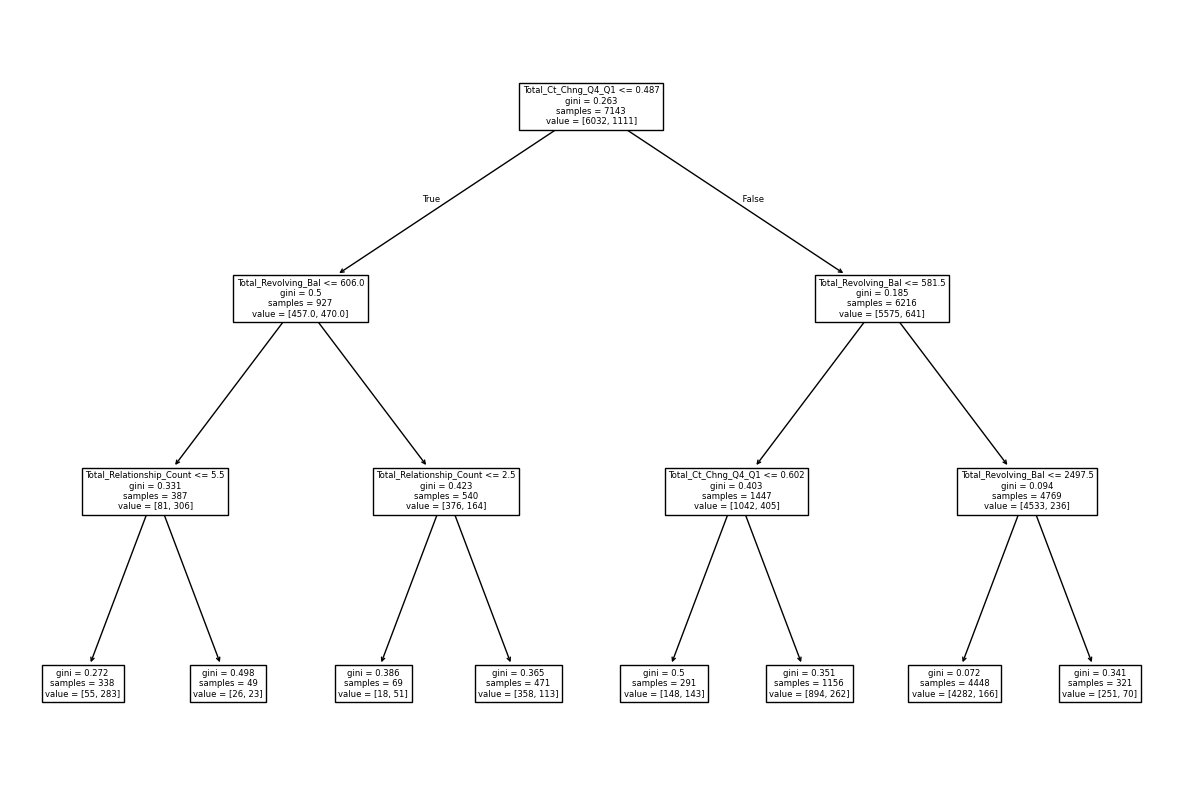

In [113]:
plt.figure(figsize=(15,10))
tree.plot_tree(DT,
                feature_names=X_treino.columns)
plt.show()

# Interpretabilidade

Métodos que serão apresentados:

- Importância das variáveis
- PDP e ICE plot
- LIME
- SHAP values
- Contrafactuais

## Importância das variáveis

In [66]:
# Função que faz o gráfico da importância das variáveis

def plot_feature_importance(importance, names, model_type):
    # importance é a variável dos valores de importância: MODELO.feature_importances_
    # names é a variável com os nomes para os respectivos valores de importância: MODELO.feature_names_in_
    # model_type é a variável string com o nome do modelo

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Cria dicionário com nomes das variáveis e com os valores de importância
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    # Ordena de forma decrescente a importância das variáveis
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    # Define o tamanho da imagem
    plt.figure(figsize=(10,8))

    # Gráfico 
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    # Rótulos
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

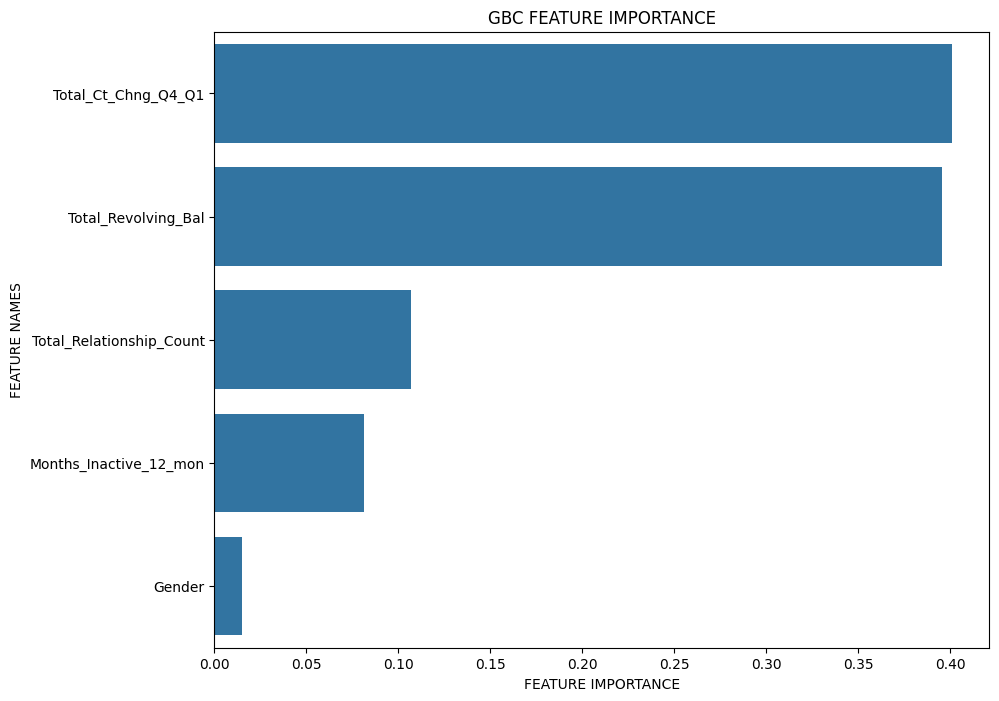

In [67]:
plot_feature_importance(GBC.feature_importances_, GBC.feature_names_in_, 'GBC')

### Vantagens

- Representa de forma simples as variáveis que mais são usadas nos splits das árvores

### Desvantagens

- Não conseguimos entender a relação das variáveis mais ou menos importantes com a variável target

## PDP (Partial Dependence Plot) e ICE Plot (Individual Conditional Expectation)

O gráfico de dependência parcial é um método agnóstico, com uma representação visual do comportamento médio do valor de uma variável, sem alterar os valores das demais variáveis, no modelo $\hat{f}(X)$. Seja $S$ o conjunto das variáveis que se deseja verificar o comportamento e $C$ o conjunto das variáveis restantes. A função de dependência parcial é:

$$
\hat{f}_{S}(x_{s}) = E_{X_{C}}[\hat{f}_{S}(x_{s},X_{C})] = \int \hat{f}_{S}(x_{s},X_{C})d\mathbb{P}(X_{C}).
$$

Ou seja, a marginalização ou isolamento da função estimada em um ponto ($x_{s}$) em relação aos demais valores das variáveis ($x_{c}$). 

O ICE plot mostra como as predições para cada instância ($\hat{f}$) mudam com a mudança dos valores da própria feature.

In [61]:
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
import matplotlib.pyplot as plt

Abaixo, temos o gráfico de dependência parcial (PDP) para total de crédito rotativo no cartão de crédito (Total_Revoling_Bal), mudança de quantidade de transações no quarto e primeiro trimestre (Total_Ct_Chng_Q4_Q1) e as curvas de nível para a relação das duas variáveis.

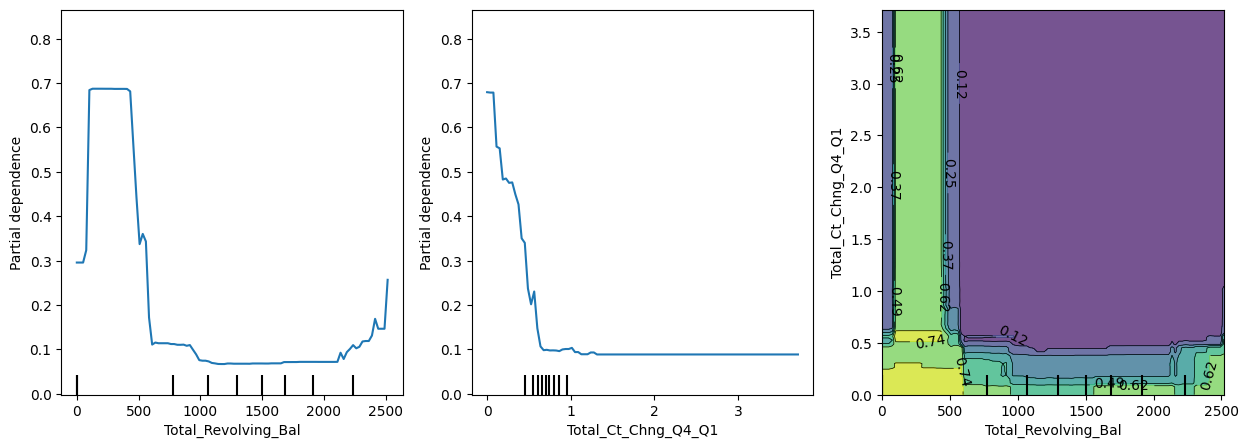

In [118]:
features = [0, 1, (0, 1)]
_, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
PartialDependenceDisplay.from_estimator(GBC, 
                                        X_treino, 
                                        features, 
                                        ax=ax,
                                        kind='average',
                                        response_method='predict_proba',
                                        method='brute',
                                        percentiles=(0,1))
plt.show()

Abaixo, temos os gráficos de dependência parcial para cada observação (ICE plot) e o valor médio em vermelho, que representa o PDP da variável de interesse.

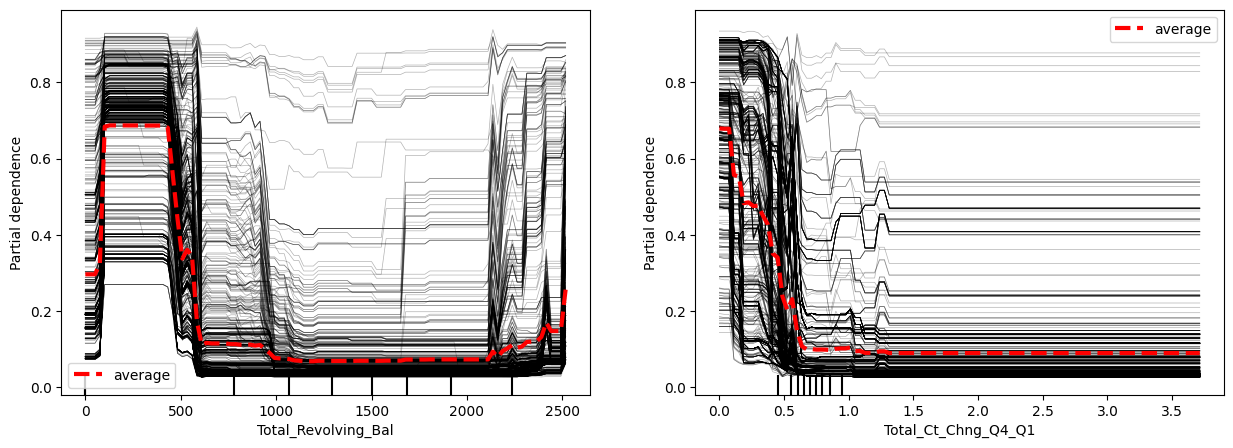

In [124]:
features = [0, 1]
_, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
PartialDependenceDisplay.from_estimator(GBC, 
                                        X_treino, 
                                        features, 
                                        ax=ax,
                                        kind='both',
                                        ice_lines_kw={'color': 'black'},
                                        pd_line_kw={'color': 'red', 'lw': 3, 'linestyle': '--'},
                                        response_method='predict_proba',
                                        method='brute',
                                        percentiles=(0,1))
plt.show()

Uma versão mais arrumada do gráfico acima é centralizar as curvas individuais em relação ao valor médio (linha vermelha). Dessa forma, cada ponto da curva preta é subtraída da curva vermelha. 

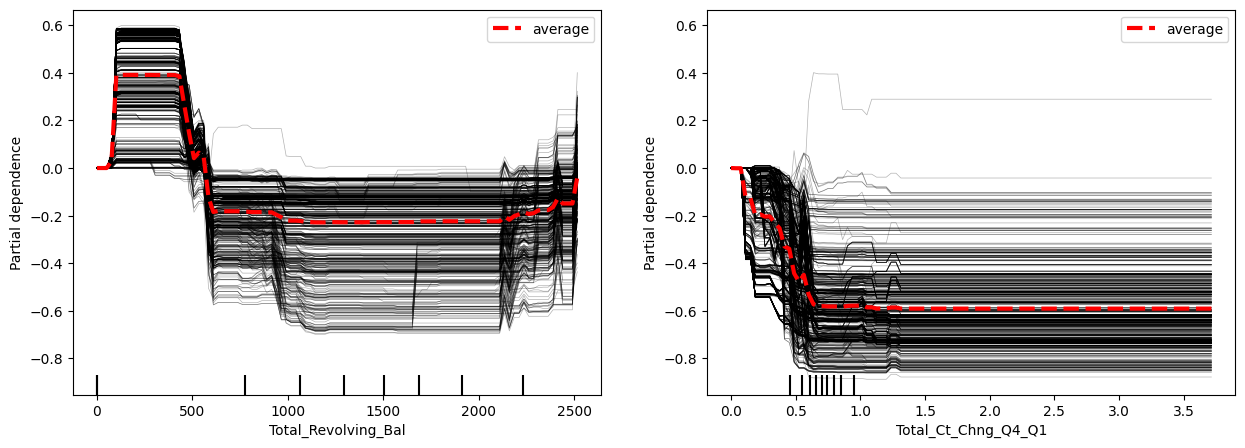

In [125]:
features = [0, 1]
_, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
PartialDependenceDisplay.from_estimator(GBC, 
                                        X_treino, 
                                        features, 
                                        ax=ax,
                                        kind='both',
                                        centered=True,
                                        ice_lines_kw={'color': 'black'},
                                        pd_line_kw={'color': 'red', 'lw': 3, 'linestyle': '--'},
                                        response_method='predict_proba',
                                        method='brute',
                                        percentiles=(0,1))
plt.show()

### Vantagens

- Fácil implementação e de entender

- O gráfico PODE apresentar uma relação exata entre o modelo e a variável explicativa, desde que esta última não esteja correlacionada com outras

- Captura relações positivas, negativas, não lineares ou ausência de relacionamento com a variável resposta

### Desvantagens

- Assume intependência das variáveis

- Não é possível ver a interação entre duas variáveis

- Se uma variável tem metade dos valores com relação positiva e outra metade negativa, o efeito real da variável não pode ser avaliado. Isso gera uma linha horizontal.

- Pode gerar combinações de variáveis pouco prováveis de acontecer

## LIME (Local Interpretable Model-Agnostic Explanations)

LIME é um método agnóstico que nos ajuda a entender o porque o modelo direcionou para o resultado $\hat{f}$, para um indivíduo. A ideia é usar um modelo substitudo (surrogate model) mais simples em uma proximidade da observação que se deseja estudar, em geral um modelos linear ou até mesmo uma árvore de decisão simples, para entender quais variáveis impactam mais na predição, mas não a magnitude do impacto de fato no caso do modelo linear.

Resumidamente, a aproximação e interpretação local de um ponto é obtida pela otimização da equação:

$$
\xi(x) = argmin_{g \in G} L(f,g,K_{x}) + \Omega(g),
$$
$$
L(f,g,K_{x}) = \sum_{z, z' \in Z} K_{x}(z)(f(z) - g(z'))².
$$

$G$ é a família de modelos interpretáveis. Em geral, modelos lineares esparços;
$L$ é a função de perda entre o modelo interpretável e o modelo complexo;
$K$ é um kernel que estabelece a proximidade do ponto de interesse em relação aos demais pontos vizinhos;
$f$ é o modelo complexo;
$g$ é o modelo substituto interpretável;
$\Omega$ é uma técnica de regularização para que o modelo $g$ seja o mais simples possível (uso do Lasso, Ridge ou ElasticNet).


Passos para o algoritmo do LIME:

1. Selecionar a observação que queremos explicar. Representado pelo ponto preto, na figura abaixo;
2. Gere observações com base nas informações de treino. Essa amostra é gerada em todo o espaço das variáveis. Representado pelos "x", na figura abaixo;
    - As amostras são geradas com o uso de uma distribuição normal para as variáveis contínuas $X$~$N(\mu,\sigma ^2)$ e a distribuição multinomial para as variáveis categóricas com $p_{j} = \frac{n_{j}}{n}$, com $n_{j} :=$ número de vezes que a categoria $j$ aparece.
3. Coloque um peso para cada observação. Queremos entender o comportamento do modelo substituto ao redor da observação que queremos explicar;
    - Para isso usa-se um kernel gaussiano: $K(x,x') = \exp(\frac{||x -x'||_{2} ^2}{\sigma ^2})$. Se aumentarmos muito $\sigma ^2$ consideraremos mais observações distantes do ponto de interesse e se diminuirmos muito, poucas observações estarão para explicar aquele ponto.
    - $\sigma ^2 = 0.75 * \sqrt{(\#vars)}$, $\#vars$ é a quantidade de variáveis.
4. Realize as predições para as observações geradas e obtenha a target estimada;
5. Treine o modelo com a amostra gerada;
    - Para o treino do modelo as variáveis numéricas são discretizadas, geralmente, em quartis.
6. Interpretação do modelo substituto.

<div>
<img src="Ex1.png" width="1000"/>
</div>

In [45]:
X_treino.columns

Index(['Total_Revolving_Bal', 'Total_Ct_Chng_Q4_Q1',
       'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Gender'],
      dtype='object')

In [35]:
# https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=show_in_notebook#module-lime.lime_tabular

explainer = LimeTabularExplainer(X_treino.values,
                                 feature_names = X_treino.columns,
                                 class_names = ['Não churn','Churn'],
                                 categorical_features = [4],
                                 mode = 'classification', 
                                 random_state = 123)

As barras e cores azuis representam impacto negativo e as barras e cores laranjas representam impacto positivo. 

In [36]:
exp = explainer.explain_instance(X_treino.iloc[0,:],
                                 GBC.predict_proba,
                                 num_features = 10)
exp.show_in_notebook(show_table = True)

/home/hugo/Documents/Git_GitHub/IML_XAI/Codigos/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/hugo/Documents/Git_GitHub/IML_XAI/Codigos/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/hugo/Documents/Git_GitHub/IML_XAI/Codigos/lib/python3.12/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys 

In [30]:
# Target real

y_treino[0]

np.int64(0)

In [31]:
# Predição pelo modelo 

GBC.predict_proba(X_treino)[0]

array([0.95889385, 0.04110615])

In [43]:
# Intercepto do modelo linear

exp.intercept

{1: np.float64(0.23029921099105147)}

In [42]:
# Coeficientes do modelo linear

exp.local_exp

{1: [(np.int64(0), np.float64(-0.11662792442739385)),
  (np.int64(1), np.float64(-0.06262545037970467)),
  (np.int64(3), np.float64(0.049579989210457705)),
  (np.int64(2), np.float64(-0.048768281232569176)),
  (np.int64(4), np.float64(0.0035743544734642384))]}

In [44]:
# Predição usando o Surrogate Model

exp.local_pred

array([0.0554319])

In [72]:
#fig = exp.as_pyplot_figure(label=1)
#plt.tight_layout()
#plt.show()

In [129]:
#pd.DataFrame(GBC.predict_proba(X_treino)[:,1])[pd.DataFrame(GBC.predict_proba(X_treino)[:,1])>.8].dropna()

In [40]:
exp = explainer.explain_instance(X_treino.iloc[16],
                                 GBC.predict_proba,
                                 num_features = 10)

exp.show_in_notebook(show_table = True)

/home/hugo/Documents/Git_GitHub/IML_XAI/Codigos/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/hugo/Documents/Git_GitHub/IML_XAI/Codigos/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/hugo/Documents/Git_GitHub/IML_XAI/Codigos/lib/python3.12/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys 

In [71]:
# Target real

y_treino.iloc[16]

np.int64(1)

In [32]:
# Predição pelo modelo 

GBC.predict_proba(X_treino)[16]

array([0.15124364, 0.84875636])

In [73]:
# Intercepto do modelo linear

exp.intercept

{1: np.float64(0.03297725931638981)}

In [74]:
# Coeficientes do modelo linear

exp.local_exp

{1: [(np.int64(0), np.float64(0.3789889992343699)),
  (np.int64(1), np.float64(0.21135370640392565)),
  (np.int64(2), np.float64(0.09269596492314017)),
  (np.int64(3), np.float64(-0.0709689198771102)),
  (np.int64(4), np.float64(0.017196559855506416))]}

In [77]:
# Predição usando o Surrogate Model

exp.local_pred

array([0.66224357])

In [76]:
#fig = exp.as_pyplot_figure(label=1)

Também é possível ter uma ideia de do comportamento global dos coeficientes da regressão. Abaixo, analisamos o comportamento médio dos pesos para as variáveis do modelo.

In [78]:
def retorna_coefs(exp):
    
    exp_list = exp.as_map()[1]
    exp_list = sorted(exp_list, key = lambda x: x[0])
    exp_peso = [x[1] for x in exp_list]

    return exp_peso

In [85]:
pesos = []

for x in X_treino.values[0:100]:

    exp = explainer.explain_instance(x,
                                 GBC.predict_proba,
                                 num_features = 10)
    
    exp_peso = retorna_coefs(exp)
    pesos.append(exp_peso)

    pesos_LIME = pd.DataFrame(data=pesos, columns=X_treino.columns)

/home/hugo/Documents/Git_GitHub/IML_XAI/Codigos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/home/hugo/Documents/Git_GitHub/IML_XAI/Codigos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/home/hugo/Documents/Git_GitHub/IML_XAI/Codigos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/home/hugo/Documents/Git_GitHub/IML_XAI/Codigos/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/home/hugo/Documents/Git_GitHub/IML_XAI/Codi

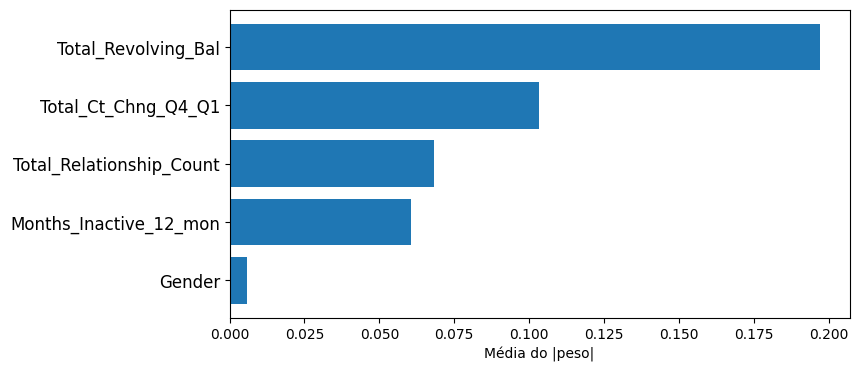

In [92]:
abs_mean = pesos_LIME.abs().mean(axis=0)
abs_mean = pd.DataFrame(data={'feature': abs_mean.index, 'abs_mean': abs_mean})
abs_mean = abs_mean.sort_values('abs_mean')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8,4))

y_sticks = range(len(abs_mean))
y_labels = abs_mean.feature

plt.barh(y = y_sticks, width=abs_mean.abs_mean)
plt.yticks(ticks=y_sticks, labels=y_labels, size = 12)
plt.xlabel('Média do |peso|')
plt.show()

### Vantagens

- Pode ser aplicado para contextos de regressão, classificação (texto e imagem)

- Fácil de implementar

### Desvantagens

- Precisa de cuidados para não interpretar o resultado do modelo substituto como um possível impacto do modelo estimado $\hat{f}$

- Alterações de parâmetros para que a interpretabilidade se adeque as necessidades

## SHAP (SHapley Additive exPlanations)

O Shapley value vem da teoria dos jogos cooperativos, que procura responder quais são os possíveis resultados com a cooperação no jogo, quais são os tipos de coalizões que podem ser formadas e como distribuir os ganhos entre os jogadores.

SHAP é um método agnóstico, para interpretabilidade local e global do modelo. Conseguimos entender a relação das variáveis explicativas com a resposta do modelo e entender o porque o modelo apontou o resultado final $\hat{f}$. Há também os métodos baseados em famílias de modelos (não agnósticos) como o Tree SHAP (para modelos baseados em árvores), o Deep SHAP (para redes neurais) e Kernel SHAP (modelos lineares).

Dado um um jogo colaborativo (modelo de ML ou estatístco) $G = (N, \nu)$, $N$ é o conjunto de jogadores (variáveis), com $n$ jogadores, e $\nu$ é uma função de valor (função estimada pelo modelo $\hat{f}$). O valor de shapley para o jogador $i$ (para o valor da variável) é:

$$
\phi_{i}(N, \nu) = \frac{1}{n!} \sum_{S \subseteq N - \{i\}} |S|!(n-1-|S|)! [ \nu(S\cup \{i\}) - \nu(S)].
$$

Pela diferença $\nu(S\cup \{i\}) - \nu(S)$ conseguimos saber qual a contribuição do valor da variável $i$ na coalizão $S$. A combinação $|S|!(n-1-|S|)!$ nos fornece as diferentes composições da coalizão $S$, com tamanho $|S|$. E o $\frac{1}{n!}$ nos fornece a contribuição média do valor da variável $i$ em todas as coalizões.

Como a coalizão é um conjunto de subconjuntos do conjunto de variáveis, então a quantidade total de coalizões pode ser dada por $2^{n}$. Se existir 10 variáveis, a quantidade total de coalizões será de 1024. Dessa forma, aproximações são utilizadas como os métodos baseados em famílias de modelos descritos acima.

<div>
<img src="Ex2.png" width="1000"/>
</div>

In [12]:
explainer = shap.TreeExplainer(GBC)
shap_values = explainer(X_treino)

In [ ]:
# https://mariogarcia.github.io/blog/2021/03/ml_decision_functions.html
# https://www.geeksforgeeks.org/ml-decision-function/

GBC.decision_function(X_treino).mean()

np.float64(-2.2340579134480314)

In [38]:
GBC.decision_function(X_treino)[0:20]

array([-3.1496226 , -1.45333994, -0.73641747, -3.42541346, -2.75326231,
       -0.97951308, -3.3103623 , -1.44864995, -2.63229005, -3.3767649 ,
       -2.89652087, -3.17979244, -2.09075762, -3.12125461, -2.34954188,
        1.00653648,  1.7248801 ,  0.02288429, -3.134155  , -1.70052575])

In [39]:
GBC.predict(X_treino)[0:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0])

In [13]:
shap_values

.values =
array([[-0.6011297 , -0.35237294, -0.15605421,  0.18522371,  0.00876846],
       [ 1.25773467, -0.2866994 , -0.21265856,  0.01945032,  0.00289094],
       [ 1.41860421,  0.45329216, -0.24478396, -0.11145351, -0.01801846],
       ...,
       [-0.63085234, -0.3551684 , -0.14813034,  0.1794182 ,  0.00899835],
       [-0.41403563,  2.38072706,  0.12590647,  0.31659333, -0.13255637],
       [ 0.94646472, -0.48041968,  0.64691225, -0.1079134 ,  0.02552141]])

.base_values =
array([-2.23405791, -2.23405791, -2.23405791, ..., -2.23405791,
       -2.23405791, -2.23405791])

.data =
array([[1.088e+03, 9.500e-01, 5.000e+00, 3.000e+00, 1.000e+00],
       [0.000e+00, 6.480e-01, 6.000e+00, 2.000e+00, 1.000e+00],
       [0.000e+00, 5.510e-01, 6.000e+00, 2.000e+00, 0.000e+00],
       ...,
       [1.178e+03, 8.640e-01, 4.000e+00, 3.000e+00, 1.000e+00],
       [2.180e+03, 2.000e-01, 3.000e+00, 3.000e+00, 0.000e+00],
       [2.517e+03, 7.860e-01, 2.000e+00, 2.000e+00, 0.000e+00]])

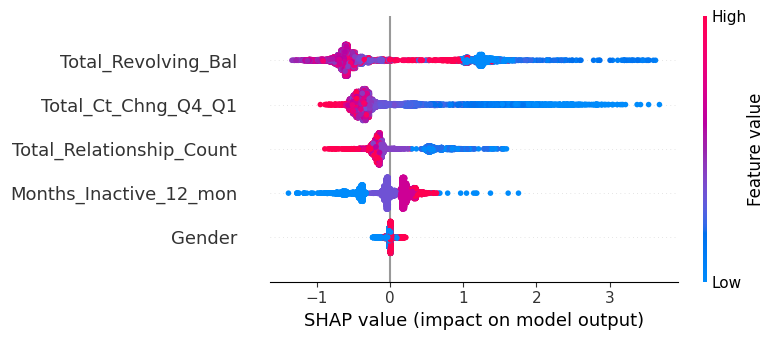

In [40]:
shap.summary_plot(shap_values.values, X_treino)

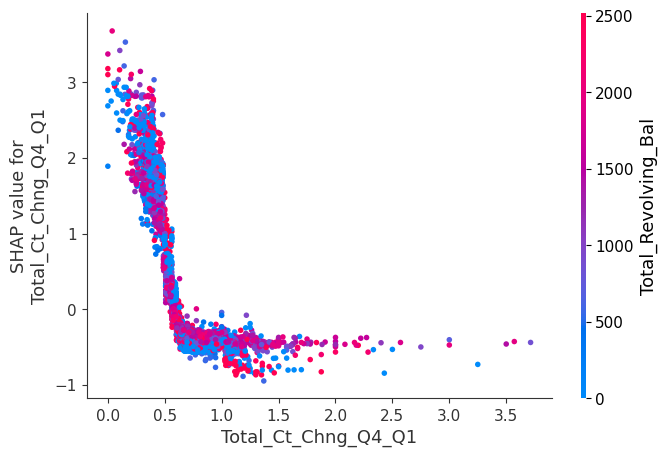

In [43]:
shap.dependence_plot('Total_Ct_Chng_Q4_Q1', shap_values.values, X_treino) #interaction_index='Gender'

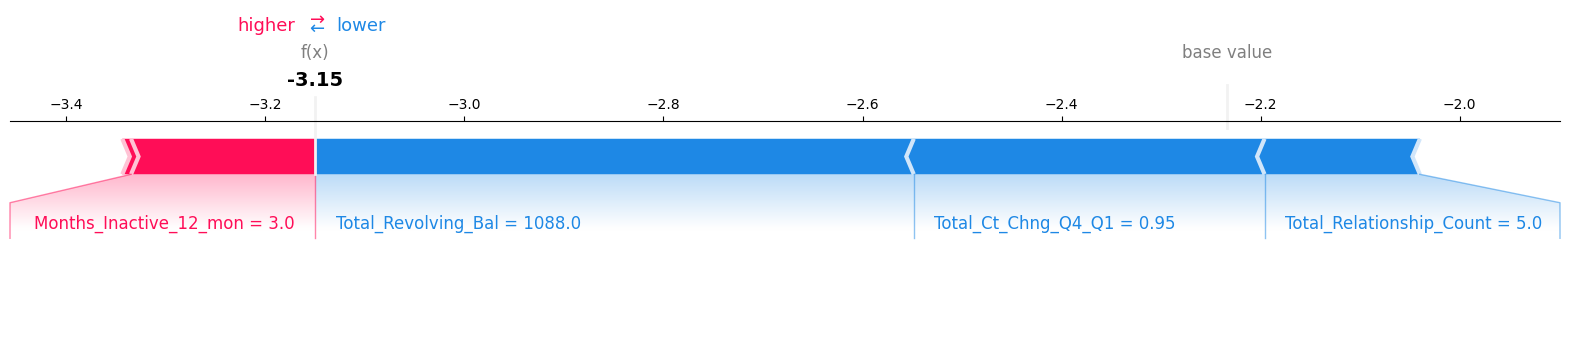

In [63]:
shap.force_plot(explainer.expected_value, shap_values.values[0], X_treino.iloc[0,:], matplotlib = True)

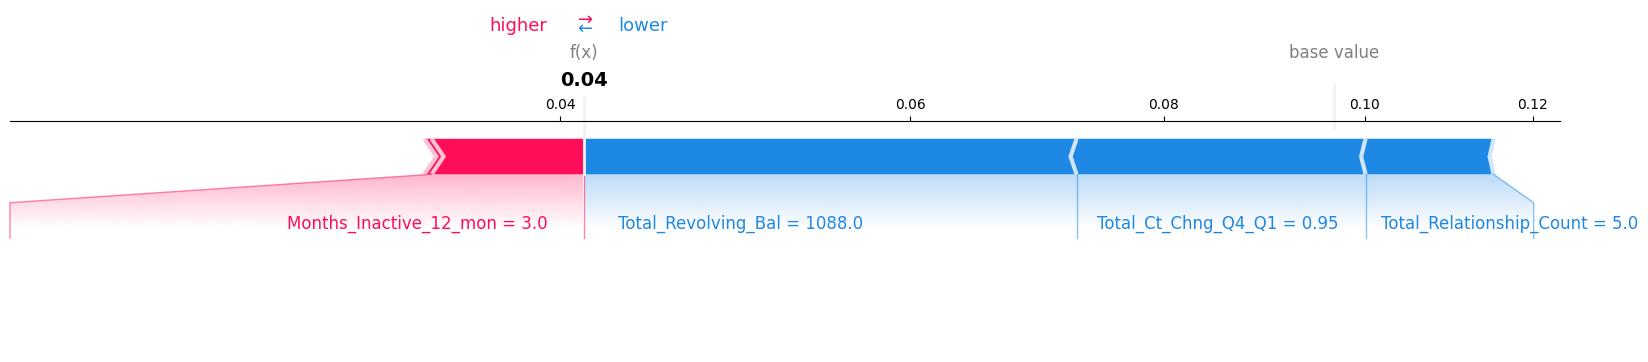

In [59]:
shap.force_plot(explainer.expected_value, shap_values.values[0], X_treino.iloc[0,:], matplotlib = True, link='logit')

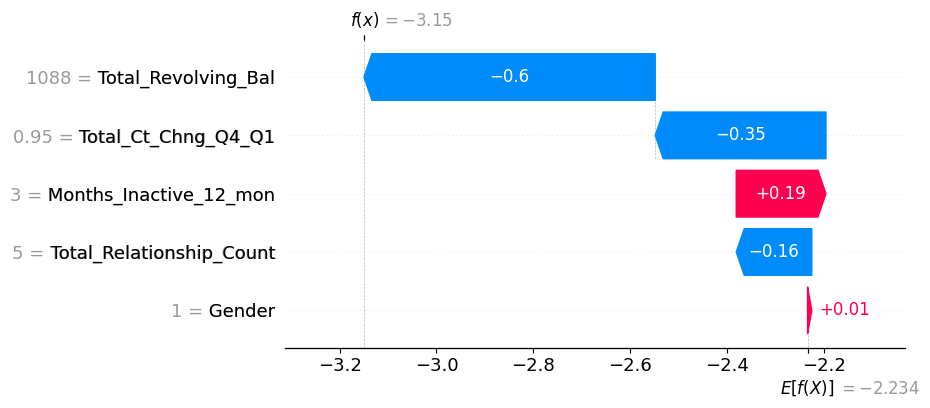

In [62]:
shap.plots.waterfall(shap_values[0])

### Vantagens

- Pode ser aplicado para contextos de regressão, classificação (texto e imagem)

- Fácil de implementar

- Satisfaz propriedades como eficiência, simetria, dummy e aditividade - https://christophm.github.io/interpretable-ml-book/shapley.html

### Desvantagens

- Exige uma curva de aprendizado para a compreensão gráfica

- A medida que o conjunto de dados aumenta a complexidade de se obter os shap values aumenta e amostras são necessárias. Isso pode comprometer a interpretação global
- https://towardsdatascience.com/the-limitations-of-shap-703f34061d86

## Explicações Contrafactuais

Os métodos anteriores nos ajudam a entendem o porque uma determinada observação recebeu aquele resultado final de classificação ou regressão $\hat{f}$. As explicações contrafactuais buscam responder o "como", localmente. Como a solicitação de um empréstimo pode ser aceita? Como um cliente pode passar a ser não churn? 

Por exemplo: agora a predição de um cliente ser churn é de 90%. Se o cliente **aumentar a quantidade de transações no cartão de crédito para 0.85 e aumentar a quantidade de produtos que tem com o banco para 8** (contrafactual), a predição seria de 70%.

Uma definição simples de contrafactual é: a menor mudança que precisamos fazer no valor de uma variável para alterar o valor da predição. Matematicamente, poderíamos escrever como segue: $argmin_{x'} d(x,x')$, tal que $\hat{f}(x') = c$, ou seja, procura-se um ponto $x'$ próximo de $x$ de modo que a predição $\hat{f}$ seja diferente.

Um ponto importante é que pode haver mais de uma observação $x'$ que nos forneça uma solução interessante para o problema. Isso é conhecido como Rashomon effect.

https://github.com/interpretml/DiCE?tab=readme-ov-file

<div>
<img src="https://camo.githubusercontent.com/cf2972905316b6109ee061d4dd97edb7fc46e0c83746c06cf818e817ec72b7ce/68747470733a2f2f7777772e6d6963726f736f66742e636f6d2f656e2d75732f72657365617263682f75706c6f6164732f70726f642f323032302f30312f4d53522d416d69745f31343030783738382d76332d31626c6f672e676966" width="1000"/>
</div>

In [72]:
data_dice = dice_ml.Data(dataframe = pd.concat([X_treino, y_treino], axis=1),
                         continuous_features = ['Total_Revolving_Bal', 'Total_Ct_Chng_Q4_Q1', 'Total_Relationship_Count', 'Months_Inactive_12_mon'],
                         categorical_features = ['Gender'],
                         outcome_name = 'Attrition_Flag')

In [73]:
GBC_dice = dice_ml.Model(model=GBC,
                         backend='sklearn')

In [74]:
explainer_dice = dice_ml.Dice(data_dice,
                              GBC_dice,
                              method='random')

In [92]:
input_data = pd.DataFrame(X_treino.iloc[0]).transpose()
input_data['Total_Relationship_Count'] = input_data['Total_Relationship_Count'].astype('int')
input_data['Months_Inactive_12_mon'] = input_data['Months_Inactive_12_mon'].astype('int')
input_data['Gender'] = input_data['Gender'].astype('int')

In [94]:
cf = explainer_dice.generate_counterfactuals(input_data,
                                             total_CFs=3,
                                             desired_class='opposite')

cf.visualize_as_dataframe(show_only_changes=True)

  0%|          | 0/1 [00:00<?, ?it/s]/home/hugo/Documents/Git_GitHub/IML_XAI/Codigos/lib/python3.12/site-packages/dice_ml/explainer_interfaces/dice_random.py:116: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  candidate_cfs.at[k, selected_features[k][0]] = random_instances.at[k, selected_features[k][0]]
100%|██████████| 1/1 [00:00<00:00,  6.23it/s]

Query instance (original outcome : 0)


Total_Revolving_Bal  Total_Ct_Chng_Q4_Q1  Total_Relationship_Count  \
0               1088.0                 0.95                         5   

   Months_Inactive_12_mon  Gender  Attrition_Flag  
0                       3       1               0


Diverse Counterfactual set (new outcome: 1)


Total_Revolving_Bal Total_Ct_Chng_Q4_Q1 Total_Relationship_Count  \
0               295.7                   -                        -   
1                93.2                   -                        -   
2               406.9                   -                        -   

  Months_Inactive_12_mon Gender Attrition_Flag  
0                      -      -            1.0  
1                      -    0.0            1.0  
2                      -      -            1.0

In [95]:
features_to_vary = ['Total_Revolving_Bal',
                    'Total_Ct_Chng_Q4_Q1',
                    'Total_Relationship_Count',
                    'Months_Inactive_12_mon']

permitted_range = {'Total_Revolving_Bal': [500, 2000],
                   'Total_Ct_Chng_Q4_Q1': [0.5, 0.99],
                   'Total_Relationship_Count': [2,6],
                   'Months_Inactive_12_mon': [3,6]}

cf = explainer_dice.generate_counterfactuals(input_data,
                                             total_CFs=3,
                                             desired_class='opposite',
                                             permitted_range=permitted_range,
                                             features_to_vary=features_to_vary)
cf.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

Query instance (original outcome : 0)


Total_Revolving_Bal  Total_Ct_Chng_Q4_Q1  Total_Relationship_Count  \
0               1088.0                 0.95                         5   

   Months_Inactive_12_mon  Gender  Attrition_Flag  
0                       3       1               0


Diverse Counterfactual set (new outcome: 1)


Total_Revolving_Bal Total_Ct_Chng_Q4_Q1 Total_Relationship_Count  \
0               503.5                   -                      2.0   
1               506.9                 0.5                        -   
2               506.9                 0.5                        -   

  Months_Inactive_12_mon Gender Attrition_Flag  
0                    5.0      -            1.0  
1                    6.0      -            1.0  
2                      -      -            1.0